In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
import pandas as pd
import joblib
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import StratifiedKFold


from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from keras.layers import Input, Dense, GlobalAveragePooling2D, UpSampling2D, add, concatenate, Conv2D, Lambda, BatchNormalization, MaxPool2D, LSTM, GRU, Reshape, Flatten, Dropout, Layer, Embedding, MultiHeadAttention, LayerNormalization, GlobalMaxPooling1D

In [2]:
X1 = np.array(joblib.load("Kfold/features/0.pkl"))
df1 = pd.read_csv("Kfold/Dataframe/0.csv", header = 0, index_col=0)

X2 = np.array(joblib.load("Kfold/features/1.pkl"))
df2 = pd.read_csv("Kfold/Dataframe/1.csv", header = 0, index_col=0)

X3 = np.array(joblib.load("Kfold/features/2.pkl"))
df3 = pd.read_csv("Kfold/Dataframe/2.csv", header = 0, index_col=0)

X4 = np.array(joblib.load("Kfold/features/3.pkl"))
df4 = pd.read_csv("Kfold/Dataframe/3.csv", header = 0, index_col=0)

masks1 = joblib.load("Kfold/Masks/0.pkl")
masks2 = joblib.load("Kfold/Masks/1.pkl")
masks3 = joblib.load("Kfold/Masks/2.pkl")
masks4 = joblib.load("Kfold/Masks/3.pkl")

In [3]:
X = np.concatenate((X1, X2, X3, X4), axis = 0)
masks = np.concatenate((masks1, masks2, masks3, masks4), axis = 0)

df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)
df4.reset_index(drop=True, inplace=True)

df = pd.concat( [df1, df2, df3, df4], axis=0) 

In [4]:
df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,15,11,signingsavvy,test,https://www.signingsavvy.com/signs/mp4/7/7493.mp4,0,634,61,12,227,192,accident
1,25,-1,1,1,12,aslsearch,train,http://www.aslsearch.com/signs/videos/accident...,0,639,180,45,574,400,accident
2,25,-1,1,17,41,aslsearch,val,http://www.aslsearch.com/signs/videos/africa.mp4,0,1398,236,33,493,400,africa
3,25,-1,1,4,11,signingsavvy,val,https://www.signingsavvy.com/signs/mp4/9/9194.mp4,0,1560,43,3,212,192,ago
4,25,-1,1,5,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/9/9196.mp4,0,1561,34,0,218,192,ago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,25,-1,1,15,28,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/4...,0,64280,20,13,258,240,yes
511,25,-1,1,19,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,64281,222,13,524,414,yes
512,25,-1,1,23,4,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,64283,625,111,1483,1063,yes
513,25,-1,1,14,42,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/5...,0,64304,39,0,278,240,yesterday


In [36]:
id_train = list(df[df.split=="train"].index)
id_val = list(df[df.split=="val"].index)
id_test = list(df[df.split=="test"].index)

In [43]:
X_train = np.take(X, id_train, axis = 0)
X_val = np.take(X, id_val, axis = 0)
X_test = np.take(X, id_test, axis = 0)

masks_train = np.take(masks, id_train, axis = 0)
masks_val = np.take(masks, id_val, axis = 0)
masks_test = np.take(masks, id_test, axis = 0)

## Prepare dataset

In [40]:
encoder = pickle.load(open("reduced one hot encoder", 'rb'))
y_train = encoder.transform(np.array(list(df[df.split=="train"]["gloss"])).reshape(-1,1)).toarray()
y_val = encoder.transform(np.array(list(df[df.split=="val"]["gloss"])).reshape(-1,1)).toarray()
y_test = encoder.transform(np.array(list(df[df.split=="test"]["gloss"])).reshape(-1,1)).toarray()

In [41]:
le = pickle.load(open("reduced label encoder", 'rb'))
le_train = le.transform(np.array(list(df[df.split=="train"]["gloss"])))
le_val = le.transform(np.array(list(df[df.split=="val"]["gloss"])))
le_test = le.transform(np.array(list(df[df.split=="test"]["gloss"])))

In [42]:
y_train.shape

(1456, 204)

In [44]:
IMG_SHAPE = X_train.shape[1:]
nb_classes = y_train.shape[-1]
masks_shape = masks.shape[1:]

In [45]:
print(X.shape, y.shape, masks.shape)

(2060, 64, 576) (2060, 204) (2060, 64)


## Model implementation

### CNN-GRU

In [46]:
input_layer = Input(shape=IMG_SHAPE)
masks_layer = Input(masks_shape, dtype='bool')
gru_layer = GRU(64)(input_layer, mask = masks_layer)
dense_layer = Dense(128, activation='relu')(gru_layer)
output_layer = Dense(nb_classes, activation='softmax')(dense_layer)

model = Model([input_layer, masks_layer], output_layer)
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 576)]    0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 64)           123264      ['input_8[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 128)          8320        ['gru_2[0][0]']            

Epoch 1/50
23/23 [==============================] - 6s 272ms/step - loss: 5.3271 - accuracy: 0.0069 - val_loss: 5.2754 - val_accuracy: 0.0086
Epoch 2/50
23/23 [==============================] - 6s 274ms/step - loss: 5.1558 - accuracy: 0.0254 - val_loss: 5.1769 - val_accuracy: 0.0114
Epoch 3/50
23/23 [==============================] - 7s 296ms/step - loss: 4.9276 - accuracy: 0.0295 - val_loss: 5.0827 - val_accuracy: 0.0114
Epoch 4/50
23/23 [==============================] - 6s 272ms/step - loss: 4.6733 - accuracy: 0.0467 - val_loss: 5.0436 - val_accuracy: 0.0229
Epoch 5/50
23/23 [==============================] - 6s 269ms/step - loss: 4.4615 - accuracy: 0.0591 - val_loss: 5.0155 - val_accuracy: 0.0229
Epoch 6/50
23/23 [==============================] - 6s 263ms/step - loss: 4.2727 - accuracy: 0.0776 - val_loss: 5.0110 - val_accuracy: 0.0257
Epoch 7/50
23/23 [==============================] - 7s 287ms/step - loss: 4.1214 - accuracy: 0.0913 - val_loss: 5.0075 - val_accuracy: 0.0514
Epoch 

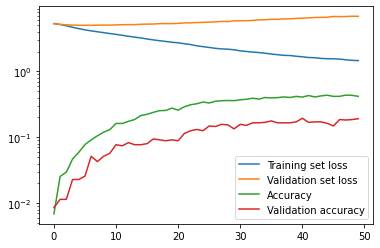

In [48]:
model.fit([X_train, masks_train], y_train, epochs=50, batch_size=64, validation_data = ([X_val, masks_val], y_val),  shuffle = True)

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

plt.yscale("log")
plt.show()

In [50]:
y_pred1 = model.predict([X_test, masks_test])         
y_pred1 = np.argmax(y_pred1, axis = 1)

print("F1 score : ", f1_score(le_test, y_pred1, average = 'weighted'))
print("Accuracy : ", accuracy_score(le_test, y_pred1))
print("Precision score : ", precision_score(le_test, y_pred1, average = 'weighted'))
print("Recall score : ", recall_score(le_test, y_pred1, average = 'weighted'))

8/8 [==============================] - 1s 94ms/step
F1 score :  0.20219347581552302
Accuracy :  0.22440944881889763
Precision score :  0.2152230971128609
Recall score :  0.22440944881889763


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
input_layer = Input(shape=IMG_SHAPE)
masks_layer = Input(masks_shape, dtype='bool')
gru_layer1 = GRU(256, return_sequences=True,)(input_layer, mask = masks_layer)
gru_layer2 = GRU(128)(gru_layer1)
dense_layer = Dense(128, activation='relu')(gru_layer2)
output_layer = Dense(nb_classes, activation='softmax')(dense_layer)

model2 = Model([input_layer, masks_layer], output_layer)
model2.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 576)]    0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 gru_3 (GRU)                    (None, 64, 256)      640512      ['input_10[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
 gru_4 (GRU)                    (None, 128)          148224      ['gru_3[0][0]']            

Epoch 1/50
23/23 [==============================] - 21s 916ms/step - loss: 5.3306 - accuracy: 0.0062 - val_loss: 5.2555 - val_accuracy: 0.0057
Epoch 2/50
23/23 [==============================] - 22s 949ms/step - loss: 5.0866 - accuracy: 0.0199 - val_loss: 5.1181 - val_accuracy: 0.0314
Epoch 3/50
23/23 [==============================] - 21s 909ms/step - loss: 4.8051 - accuracy: 0.0371 - val_loss: 5.0361 - val_accuracy: 0.0257
Epoch 4/50
23/23 [==============================] - 21s 908ms/step - loss: 4.5367 - accuracy: 0.0673 - val_loss: 4.9665 - val_accuracy: 0.0429
Epoch 5/50
23/23 [==============================] - 22s 971ms/step - loss: 4.3043 - accuracy: 0.0797 - val_loss: 4.9582 - val_accuracy: 0.0371
Epoch 6/50
23/23 [==============================] - 22s 965ms/step - loss: 4.1081 - accuracy: 0.0962 - val_loss: 4.9430 - val_accuracy: 0.0543
Epoch 7/50
23/23 [==============================] - 21s 895ms/step - loss: 3.9306 - accuracy: 0.1174 - val_loss: 4.9577 - val_accuracy: 0.0657

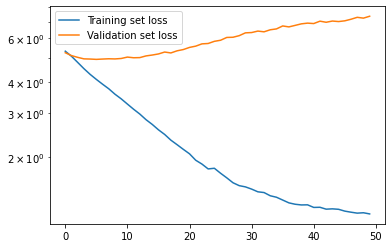

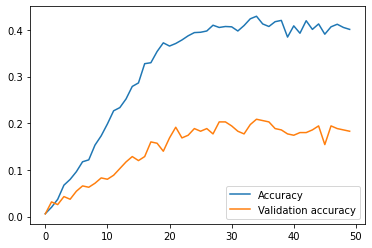

In [53]:
model2.fit([X_train, masks_train], y_train, epochs=50, batch_size=64, validation_data = ([X_val, masks_val], y_val),  shuffle = True)

plt.plot(model2.history.history['loss'])
plt.plot(model2.history.history['val_loss'])
plt.legend(["Training set loss", "Validation set loss"])
plt.yscale("log")
plt.show()

plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.legend([ "Accuracy", "Validation accuracy"])

plt.show()

In [54]:
y_pred1 = model2.predict([X_test, masks_test])         
y_pred1 = np.argmax(y_pred1, axis = 1)

print("F1 score : ", f1_score(le_test, y_pred1, average = 'weighted'))
print("Accuracy : ", accuracy_score(le_test, y_pred1))
print("Precision score : ", precision_score(le_test, y_pred1, average = 'weighted'))
print("Recall score : ", recall_score(le_test, y_pred1, average = 'weighted'))

8/8 [==============================] - 2s 257ms/step
F1 score :  0.17967754030746155
Accuracy :  0.2125984251968504
Precision score :  0.18280839895013126
Recall score :  0.2125984251968504


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
model2.save("CNN-RNN")

INFO:tensorflow:Assets written to: CNN-RNN\assets


INFO:tensorflow:Assets written to: CNN-RNN\assets


### Good result but overfitting

### With a transformer encoder

Transformers implementation from : https://keras.io/examples/vision/video_transformers/

In [55]:
class PositionalEmbedding(Layer):
    
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = Embedding(input_dim = sequence_length, output_dim = output_dim)
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        #embedding of the frame position inside a sequence
        embedded_positions  = self.position_embeddings(positions)
        return inputs + embedded_positions
    
    def compute_mask(self, inputs, mask=None):
        #Reduction of elementwise logical OR only on features
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis = -1)
        return mask
    
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3)
        self.dense_proj = Sequential([Dense(dense_dim, activation=tf.nn.gelu), Dense(embed_dim)])
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
            
        #Self attention block
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        
        #Be sure projection distribution is normal
        proj_input = self.layernorm_1(inputs + attention_output)
        
        # Prediction from self attention projection
        proj_output = self.dense_proj(proj_input)
        
        return self.layernorm_2(proj_input + proj_output)

In [56]:
num_heads = 4
sequence_length = IMG_SHAPE[0]
embed_dim = IMG_SHAPE[-1]
dense_dim = 4

In [57]:
input_layer = Input(shape=IMG_SHAPE)
positional_embedding_layer = PositionalEmbedding(sequence_length, embed_dim, name="positional_embedding_layer")(input_layer)
transformer_layer = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(positional_embedding_layer)
maxpooling_layer = GlobalMaxPooling1D()(transformer_layer)
dropout_layer = Dropout(0.2)(maxpooling_layer)
output_layer = Dense(nb_classes, activation='softmax')(dropout_layer)

model_transformer = Model([input_layer, masks_layer], output_layer)
model_transformer.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
model_transformer.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 576)]    0           []                               
                                                                                                  
 positional_embedding_layer (Po  (None, 64, 576)     36864       ['input_12[0][0]']               
 sitionalEmbedding)                                                                               
                                                                                                  
 transformer_layer (Transformer  (None, 64, 576)     5323396     ['positional_embedding_layer[0][0
 Encoder)                                                        ]']                              
                                                                                            

Epoch 1/50
23/23 [==============================] - 20s 879ms/step - loss: 6.2444 - accuracy: 0.0048 - val_loss: 5.7216 - val_accuracy: 0.0057
Epoch 2/50
23/23 [==============================] - 20s 879ms/step - loss: 5.7665 - accuracy: 0.0055 - val_loss: 5.4259 - val_accuracy: 0.0086
Epoch 3/50
23/23 [==============================] - 19s 838ms/step - loss: 5.5902 - accuracy: 0.0110 - val_loss: 5.3641 - val_accuracy: 0.0171
Epoch 4/50
23/23 [==============================] - 19s 836ms/step - loss: 5.3806 - accuracy: 0.0096 - val_loss: 5.2038 - val_accuracy: 0.0143
Epoch 5/50
23/23 [==============================] - 20s 894ms/step - loss: 5.1014 - accuracy: 0.0234 - val_loss: 5.1972 - val_accuracy: 0.0229
Epoch 6/50
23/23 [==============================] - 20s 877ms/step - loss: 4.9169 - accuracy: 0.0275 - val_loss: 5.1813 - val_accuracy: 0.0229
Epoch 7/50
23/23 [==============================] - 20s 852ms/step - loss: 4.7229 - accuracy: 0.0529 - val_loss: 5.1868 - val_accuracy: 0.0400

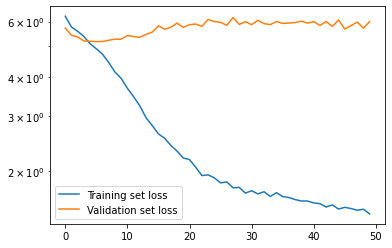

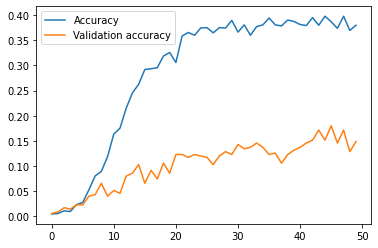

In [59]:
model_transformer.fit([X_train, masks_train], y_train, epochs=50, batch_size=64, validation_data = ([X_val, masks_val], y_val),  shuffle = True)

plt.plot(model_transformer.history.history['loss'])
plt.plot(model_transformer.history.history['val_loss'])
plt.legend(["Training set loss", "Validation set loss"])
plt.yscale("log")
plt.show()

plt.plot(model_transformer.history.history['accuracy'])
plt.plot(model_transformer.history.history['val_accuracy'])
plt.legend([ "Accuracy", "Validation accuracy"])

plt.show()

In [60]:
y_pred1 = model_transformer.predict([X_test, masks_test])         
y_pred1 = np.argmax(y_pred1, axis = 1)

print("F1 score : ", f1_score(le_test, y_pred1, average = 'weighted'))
print("Accuracy : ", accuracy_score(le_test, y_pred1))
print("Precision score : ", precision_score(le_test, y_pred1, average = 'weighted'))
print("Recall score : ", recall_score(le_test, y_pred1, average = 'weighted'))

8/8 [==============================] - 1s 181ms/step
F1 score :  0.1325896762904637
Accuracy :  0.14566929133858267
Precision score :  0.14632545931758528
Recall score :  0.14566929133858267


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
model_transformer.save("CNN-transformers")

INFO:tensorflow:Assets written to: CNN-transformers\assets


INFO:tensorflow:Assets written to: CNN-transformers\assets
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
### Continue training with a potential other validation split

In [61]:
num_heads = 8

In [62]:
input_layer = Input(shape=IMG_SHAPE)
positional_embedding_layer = PositionalEmbedding(sequence_length, embed_dim, name="positional_embedding_layer")(input_layer)
transformer_layer = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(positional_embedding_layer)
maxpooling_layer = GlobalMaxPooling1D()(transformer_layer)
dropout_layer = Dropout(0.2)(maxpooling_layer)
output_layer = Dense(nb_classes, activation='softmax')(dropout_layer)

model_transformer2 = Model([input_layer, masks_layer], output_layer)
model_transformer2.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
model_transformer2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 576)]    0           []                               
                                                                                                  
 positional_embedding_layer (Po  (None, 64, 576)     36864       ['input_13[0][0]']               
 sitionalEmbedding)                                                                               
                                                                                                  
 transformer_layer (Transformer  (None, 64, 576)     10638724    ['positional_embedding_layer[0][0
 Encoder)                                                        ]']                              
                                                                                            

Epoch 1/50
23/23 [==============================] - 36s 2s/step - loss: 6.1064 - accuracy: 0.0041 - val_loss: 5.4863 - val_accuracy: 0.0057
Epoch 2/50
23/23 [==============================] - 36s 2s/step - loss: 5.7153 - accuracy: 0.0055 - val_loss: 5.3906 - val_accuracy: 0.0057
Epoch 3/50
23/23 [==============================] - 36s 2s/step - loss: 5.5859 - accuracy: 0.0034 - val_loss: 5.3078 - val_accuracy: 0.0086
Epoch 4/50
23/23 [==============================] - 36s 2s/step - loss: 5.4482 - accuracy: 0.0117 - val_loss: 5.2056 - val_accuracy: 0.0114
Epoch 5/50
23/23 [==============================] - 37s 2s/step - loss: 5.2618 - accuracy: 0.0144 - val_loss: 5.1752 - val_accuracy: 0.0086
Epoch 6/50
23/23 [==============================] - 38s 2s/step - loss: 5.1399 - accuracy: 0.0124 - val_loss: 5.2134 - val_accuracy: 0.0143
Epoch 7/50
23/23 [==============================] - 38s 2s/step - loss: 4.9718 - accuracy: 0.0275 - val_loss: 5.3204 - val_accuracy: 0.0143
Epoch 8/50
23/23 [==

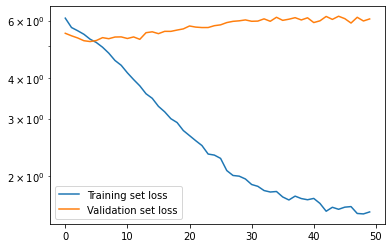

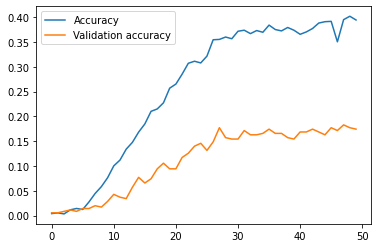

In [64]:
model_transformer2.fit([X_train, masks_train], y_train, epochs=50, batch_size=64, validation_data = ([X_val, masks_val], y_val),  shuffle = True)

plt.plot(model_transformer2.history.history['loss'])
plt.plot(model_transformer2.history.history['val_loss'])
plt.legend(["Training set loss", "Validation set loss"])
plt.yscale("log")
plt.show()

plt.plot(model_transformer2.history.history['accuracy'])
plt.plot(model_transformer2.history.history['val_accuracy'])
plt.legend([ "Accuracy", "Validation accuracy"])

plt.show()

In [65]:
y_pred1 = model_transformer2.predict([X_test, masks_test])         
y_pred1 = np.argmax(y_pred1, axis = 1)

print("F1 score : ", f1_score(le_test, y_pred1, average = 'weighted'))
print("Accuracy : ", accuracy_score(le_test, y_pred1))
print("Precision score : ", precision_score(le_test, y_pred1, average = 'weighted'))
print("Recall score : ", recall_score(le_test, y_pred1, average = 'weighted'))

8/8 [==============================] - 2s 274ms/step
F1 score :  0.13375683808754674
Accuracy :  0.1732283464566929
Precision score :  0.12875890513685792
Recall score :  0.1732283464566929


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
model_transformer2.save("CNN-transformers")

INFO:tensorflow:Assets written to: CNN-transformers\assets


INFO:tensorflow:Assets written to: CNN-transformers\assets
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
